In [18]:
import sys
from collections import OrderedDict
import pandas as pd
import numpy as np
# Load libraries
import pandas
import pandas as pd
#from pandas.plotting import scatter_matrix <-- deprecated
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [19]:
fname = 'BigData\\BigData.xlsx'
dataset = pandas.read_excel(fname)

In [20]:
# preprocessing
dataset = dataset.replace('.', np.nan)
dataset.iloc[:, 6:] = dataset.iloc[:, 6:].apply(lambda row: row.astype(float))

In [21]:
# Prepare ranges and columns for new dataset
def findRangeCols(dataset):
    rangeList = dataset.Location.values.tolist()
    rangeList = list(OrderedDict.fromkeys(rangeList)) # remove duplicates

    list0 = ['Location']
    list1 = ['WBC Severity', 'WBC Incidence', 'WBC Index', 'Disease Severity', 'Disease Incidence', 'Disease Index', 'BPA', 'Mg/ha', 'DON (ppm)']
    list1_append = ['Q25', 'Q75', 'IQR', 'MIN', 'MAX']
    colList1 = []
    colAdded = []

    # Construct columns names by merging these 2 columns
    for pre in list1:
        colList1.append(pre)
        for suf in list1_append:
            name = pre + '_' + suf
            colList1.append(name)
            colAdded.append(name)

    # Now merge with all weather params
    list3 = dataset.iloc[:, 15:].columns.tolist()
    columnsList = list0 + colList1 + list3

    return [rangeList, columnsList, colAdded]

In [22]:
# Create new df with given range and columns lists
def dfTemplate(rangeList, columnsList):
    
    colKeysList = []
    colKeysList.append(rangeList)

    # make a list of nan values
    nanList = len(rangeList)*[np.nan]
    for i in range(1, len(columnsList)):
        colKeysList.append(nanList)
    dfDic = OrderedDict(zip(columnsList, colKeysList))
    
    return pd.DataFrame.from_dict(dfDic)

# Create a dataset based on year and fill in each value fetched from the original big data
def fillNan(dataset, year, rangeList, columnsList, colAdded):
    
    if (year == 2017 or year == 2018):
        df_year = dataset[ dataset['Year'] == year ]
    else:
        df_year = dataset[ dataset['Year'] == 2017 ]
    # transform the values into float
#     df_year = df_year.apply(lambda row: row.astype(float))
    
    df = dfTemplate(rangeList, columnsList) # Make an empty df
    columnsBefore = df_year.columns.values.tolist()
    
    rangeNum = 0
    for station in rangeList:
        
        for colNum in range(6,len(columnsBefore)):
            column = columnsBefore[colNum]
            index_of_col = columnsList.index(column)
            index_q25 = index_of_col + 1
            index_q75 = index_of_col + 2
            index_iqr = index_of_col + 3
            index_min = index_of_col + 4
            index_max = index_of_col + 5
            
            dfi = df_year[ df_year['Location'].apply(lambda stat: stat == station)][column]
            
            # values to calculate
            mean = dfi.mean(axis=0)
            q_25 = dfi.quantile(.25)
            iqr = dfi.quantile(.50)
            q_75 = dfi.quantile(.75)
            mn = dfi.min()
            mx = dfi.max()
            
            try:
                sameVal = dfi.tolist()[0]
            except IndexError:
                sameVal = np.nan
            
            if colNum <= 14:
                df.loc[rangeNum, column] = mean
                df.iloc[rangeNum,index_q25] = q_25
                df.iloc[rangeNum,index_q75] = q_75
                df.iloc[rangeNum,index_iqr] = iqr
                df.iloc[rangeNum,index_min] = mn
                df.iloc[rangeNum,index_max] = mx
                
            elif (colNum > 15 and colNum <= len(columnsBefore) ):
                df.loc[rangeNum, column] = sameVal
                
            
            
        rangeNum +=1

    return df


# concatenate the df of 2017/18
def AllDataMean(dataset):
    
    allList = findRangeCols(dataset) # Get the list I need
    rangeList = allList[0]
    columnsList = allList[1]
    colAdded = allList[2]
    
    df2017 = fillNan(dataset, 2017, rangeList, columnsList, colAdded)
    df2018 = fillNan(dataset, 2018, rangeList, columnsList, colAdded)
    df2017.insert(1, 'Year', 2017)
    df2018.insert(1, 'Year', 2018)
    
    
    dfResult = pd.concat([df2017, df2018], ignore_index=True)
    dfResult.to_excel("newdata.xlsx", sheet_name='Sheet1')
    

In [23]:
#AllDataMean(dataset)

In [83]:
# Applying Regression Model on original data
columnsListB = dataset.columns.values.tolist()
depVar = dataset['Disease Incidence'].values

# Three cases for independent vars: TAV, Rain fall, RH
st1 = columnsListB.index('pcpn_JunW1')
ed1 = columnsListB.index('pcpn_SeptW4')
st2 = columnsListB.index('TAV_JunW1')
ed2 = columnsListB.index('TAV_SeptW4')
st3 = columnsListB.index('RAV_JunW1')
ed3 = columnsListB.index('RAV_SeptW4')
indepVarRain = dataset.iloc[:, st1:ed1+1]
indepVarTAV = dataset.iloc[:, st2:ed2+1]
indepVarRAV = dataset.iloc[:, st3:ed3+1]

# indepVarRain


In [84]:
# Libs
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
# import seaborn as sns; sns.set(color_codes=True)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# print('The scikit-learn version is {}.'.format(sklearn.__version__))


In [85]:
# First case:
X1 = indepVarRain
y1 = depVar
# Splitting into training and test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, random_state=0)

# fitting multiple linear regression to the training set
regressor1 = LinearRegression()
regressor1.fit(X1_train, y1_train)

# Predicting Test set results
y1_predicted = regressor1.predict(X1_test)
pred_train = regressor1.predict(X1_train)


dfComp = pd.DataFrame({'Actual': y1_test.flatten(), 'Predicted': y1_predicted.flatten()})
# plt.scatter(pred_train, pred_train - y1_train, c='b', s=20, alpha=0.5)
# plt.scatter(pred_test, pred_test - y1_test, c='g', s=20)
# plt.hlines(y=0, xmin=0, xmax=50)
# plt.title('Residual Plot using training (blue) and test (green) data')
# plt.ylabel('Residuals')

# sns.regplot(x=dfComp["Actual"], y=dfComp["Predicted"], line_kws={"color":"r","alpha":0.7,"lw":5})
# plt.scatter(X1_test, y1_test, c='b', s=20, alpha=0.5)

# count = 50
# title = 'ERI vs. Rainfall (' + str(count) + ' count)'
# name = 'Regression\\' + title + '.png'
# df1 = dfComp.head(count)
# df1.plot(kind='bar',figsize=(20,10))
# plt1.grid(which='major', linestyle='-', linewidth='0.5', color='green')
# plt1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt1.title(title)
# # plt.show()
# plt1.savefig(name)
dfComp
r2 = regressor1.score(X1_test, y1_test)
import math
r = math.sqrt(r2)
# plt.scatter(x=dfComp.Actual, y=dfComp.Predicted)
# plt.show()
# plt.savefig('result1.png')
# X1_train.shape
# a = regressor1.intercept_
# the coefs of the reg
coefficients = pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(regressor1.coef_))], axis = 1)
# coefficients
print(r2, r)


0.633408007802 0.7958693409109284


In [86]:
coefficients

0            0
0    pcpn_JunW1 -1370.139842
1    pcpn_JunW2   799.892548
2    pcpn_JunW3   -25.340088
3    pcpn_JunW4    86.267287
4    pcpn_JulW1   481.241805
5    pcpn_JulW2    70.782735
6    pcpn_JulW3   547.616855
7    pcpn_JulW4  -267.974531
8    pcpn_AugW1  -652.136769
9    pcpn_AugW2    68.362976
10   pcpn_AugW3 -1391.630972
11   pcpn_AugW4   -57.205550
12  pcpn_SeptW1   372.418106
13  pcpn_SeptW2  -856.208455
14  pcpn_SeptW3  -758.949169
15  pcpn_SeptW4  -426.486519

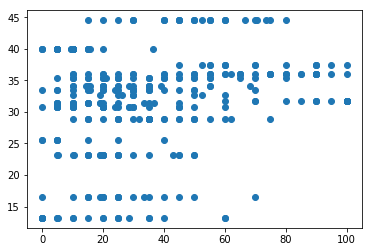

In [87]:
lst = ['pcpn_JunW3', 'pcpn_AugW4', 'pcpn_SeptW1']
predictor = indepVarRain[lst]
# Splitting into training and test set
y1 = depVar

X1_train, X1_test, y1_train, y1_test = train_test_split(predictor, y1, test_size=0.4, random_state=0)

# fitting multiple linear regression to the training set
regressor1 = LinearRegression()
regressor1.fit(X1_train, y1_train)

# Predicting Test set results
y1_predicted = regressor1.predict(X1_test)
pred_train = regressor1.predict(X1_train)

dfComp = pd.DataFrame({'Actual': y1_test.flatten(), 'Predicted': y1_predicted.flatten()})

r2 = regressor1.score(X1_test, y1_test)
import math
r = math.sqrt(r2)
plt.scatter(x=dfComp.Actual, y=dfComp.Predicted)
plt.show()

In [88]:
print(r2, r)

0.045039127952 0.2122242397842416


In [66]:
regListRain = ['pcpn_JunW2', 'pcpn_JunW4', 'pcpn_JulW1', 'pcpn_JulW2', 'pcpn_JulW3', 'pcpn_AugW2', 'pcpn_SeptW1']

In [53]:
# 2nd Case:
X2 = indepVarTAV
y2 = depVar
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=0)

# fitting multiple linear regression to the training set
regressor2 = LinearRegression()
regressor2.fit(X2_train, y2_train)

# Predicting Test set results
y2_predicted  = regressor2.predict(X2_test)
pred_train = regressor2.predict(X2_train)


dfComp2 = pd.DataFrame({'Actual': y2_test.flatten(), 'Predicted': y2_predicted.flatten()})


count = 50
title = 'ERI vs. TAV (' + str(count) + ' count)'
name = 'Regression\\' + title + '.png'
df2 = dfComp2.head(count)
df2.plot(kind='bar',figsize=(20,10))
plt2.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt2.title(title)

plt2.savefig(name)


r2 = regressor2.score(X2_test, y2_test)
import math
r = math.sqrt(r2)

coefficients2 = pd.concat([pd.DataFrame(X2.columns),pd.DataFrame(np.transpose(regressor2.coef_))], axis = 1)
coefficients2
print(r2, r)

0.633408007802 0.7958693409109251


In [54]:
# 3rd Case:
X3 = indepVarRAV
y3 = depVar
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=0)

# fitting multiple linear regression to the training set
regressor3 = LinearRegression()
regressor3.fit(X3_train, y3_train)

# Predicting Test set results
y3_predicted  = regressor3.predict(X3_test)
pred_train = regressor3.predict(X3_train)


dfComp3 = pd.DataFrame({'Actual': y3_test.flatten(), 'Predicted': y3_predicted.flatten()})


count = 50
title = 'ERI vs. RAV (' + str(count) + ' count)'
name = 'Regression\\' + title + '.png'
# df3 = dfComp3.head(count)
# df3.plot(kind='bar',figsize=(20,10))
# plt3.grid(which='major', linestyle='-', linewidth='0.5', color='green')
# plt3.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt3.title(title)

# plt3.savefig(name)


r2 = regressor3.score(X3_test, y3_test)
import math
r = math.sqrt(r2)
# dfComp3
r
N = 50
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
colors = np.random.rand(N)
# plt.scatter(x=dfComp3.Actual, y=dfComp3.Predicted, s=area,alpha=0.4)
# plt.show()
print(r2, r)

0.621198833719 0.7881616799356564


In [34]:
coefficients3 = pd.concat([pd.DataFrame(X3.columns),pd.DataFrame(np.transpose(regressor3.coef_))], axis = 1)
coefficients3

0          0
0    RAV_JunW1  10.422660
1    RAV_JunW2  -2.179131
2    RAV_JunW3 -14.026782
3    RAV_JunW4  14.900188
4    RAV_JulW1  -9.773461
5    RAV_JulW2  21.007386
6    RAV_JulW3 -14.095449
7    RAV_JulW4  14.248433
8    RAV_AugW1 -12.235583
9    RAV_AugW2  -0.852125
10   RAV_AugW3  -1.133037
11   RAV_AugW4  -8.396818
12  RAV_SeptW1   5.511101
13  RAV_SeptW2  -2.410407
14  RAV_SeptW3  -5.516974
15  RAV_SeptW4   1.064589